In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
import bisect

import myokit
from scipy.integrate import ode, solve_ivp
sys.path.append('../')
sys.path.append('../Lib')
sys.path.append('../Protocols')
from pacing_protocol import PacingProtocol
import mod_protocols
sys.path.append('../models')
from Models.ord2011JK_v1 import ORD2011

In [2]:
'''
O'Hara-Rudy CiPA v1.0 (2011)
'''
cells = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
end_time = 500
bcl = 1000
duration = 0.5
offset = 20

In [3]:
import simulator_myokit
'''
Simulation with Myokit
'''
model_path = "../mmt-model-files/ord-2011.mmt" 

protocol_myokit = myokit.pacing.blocktrain(bcl, duration, offset=offset) # period, duration, offset=0, level=1.0, limit=0
sim_myokit = simulator_myokit.Simulator(model_path, protocol_myokit, max_step=None, abs_tol=1e-08, rel_tol=1e-10)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim_myokit.name = "ORD2011"
sim_myokit.bcl = bcl

times = np.linspace(0, end_time, 5000)

simulated_models_myokit = []

start_time = time.time()

sim_myokit.simulation.set_constant('cell.mode', cells['Epicardial'])    
d = sim_myokit.simulate(times, pre_sim_type=2)
simulated_models_myokit.append(d)

print("--- %s seconds ---"%(time.time()-start_time))

--- 0.047576189041137695 seconds ---


In [4]:
import simulator_scipy
'''
Simulation with BDF
'''
protocol = PacingProtocol(level=1, start=offset, length=duration, period=bcl, multiplier=0, default_time_unit='ms')
model = ORD2011(protocol)
sim_bdf = simulator_scipy.Simulator(model)
t_span = (0, end_time)
t_eval = np.linspace(0, t_span[1], 5000)  

simulated_models_BDF = []

start_time = time.time()

model.cell.mode = cells['Epicardial']

sim_bdf.pre_simulate( pre_step=bcl*100, protocol='constant' )        

sim_bdf.simulate(t_span=t_span, t_eval=t_eval, method='LSODA', max_step=0.5, atol=1e-08, rtol=1e-10) # 1e-12, 1e-14  # 1e-08, 1e-10

simulated_models_BDF.append(copy.copy(model))

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.8866870403289795 seconds ---


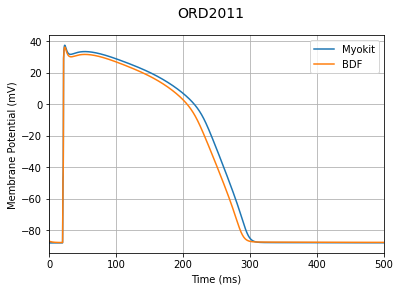

In [8]:
'''
Plot
'''
fig, ax = plt.subplots( figsize=(6,4))    
fig.suptitle(model.name, fontsize=14)
    
# ax.set_title('Simulation %d'%(simulationNo))
ax.set_xlim(bdf_m.times.min(), bdf_m.times.max())
# ax.set_ylim(ylim[0], ylim[1])
ax.set_ylabel('Membrane Potential (mV)')  
ax.set_xlabel('Time (ms)')  
ax.plot( myokit_m['engine.time'], myokit_m['membrane.V'], label='Myokit') 
ax.plot(bdf_m.times, bdf_m.V, label='BDF')        

# textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(GNa/g_fc[0], \
#             GNaL/g_fc[1], Gto/g_fc[2], PCa/g_fc[3], GKr/g_fc[4], GKs/g_fc[5], GK1/g_fc[6], Gf/g_fc[7])
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
#     ax.text(0.67, 0.60, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)    
#     fig1 = plt.gcf()
ax.legend()
ax.grid()
    
plt.show()
fig.savefig(os.path.join('Results', "ORD2011-JK-scipy"), dpi=100)

In [ ]:
print("Complete")